In [1]:
from scipy.optimize import minimize
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler
%run 2.Hicks_Henne_NEW_Final.ipynb
%run 3.Xfoil_runner_extract_value.ipynb

In [2]:
model = joblib.load('model__14_mae.joblib')
scaler = joblib.load('scaler_file__14_mae.joblib')

In [3]:
# Save the current directory
original_directory = os.getcwd()

# Navigate to another folder
os.chdir(original_directory + '\\Deformed_foils')

In [4]:
airfoil_name = '0rig_NACA0012'

CL_org, CD_org = Xfoil_runner(alpha, Re, n_iter, airfoil_name)

print(CL_org, CD_org)

0.5572 0.00848


In [5]:
feature_names = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]

In [6]:
def objective_function(design_parameters):
    design_parameters = design_parameters.reshape(1,8)
    design_parameters = pd.DataFrame(design_parameters, columns=feature_names)
    design_parameters = scaler.transform(design_parameters)
    
    predictions = model.predict(design_parameters)
    CL = predictions[0, 0]
    CD = predictions[0, 1]
    
    return -CL

def CD_constraint(design_parameters):
    design_parameters = design_parameters.reshape(1,8)
    design_parameters = pd.DataFrame(design_parameters, columns=feature_names)
    design_parameters = scaler.transform(design_parameters)
    
    predictions = model.predict(design_parameters)
    CL = predictions[0, 0]
    CD = predictions[0, 1]  
    
    return CD_org - CD
    
def area_constraint(design_parameters):
    design_parameters = np.array(design_parameters).reshape((1, 8))
    i = 0
    y_mod = hicks_henne_overall(x, y , n, design_parameters, i, w, xM)
    polygon1 = Polygon(zip(x, y))
    area_orig = polygon1.area
    polygon2 = Polygon(zip(x, y_mod))
    area_mod = polygon2.area
    return area_orig - area_mod


In [7]:
bounds = [(-limit, limit), (-limit, limit), (-limit, limit), (-limit, limit), (-limit, limit), (-limit, limit), (-limit, limit), (-limit, limit) ]
#scale
initial_guess = np.full(8, -0.002)

In [8]:
from shapely.geometry import Polygon
constraints = [{'type': 'eq', 'fun': CD_constraint},{'type': 'eq', 'fun': area_constraint}]
# constraints = [{'type': 'ineq', 'fun': CD_constraint}]
result = minimize(objective_function, initial_guess, bounds=bounds, constraints=constraints, method='SLSQP')

optimal_design_parameters = result.x

1/1 [==============================] - 0s 24ms/step


In [9]:
if result.success:
    print("Optimization successful!")
else:
    print("Optimization failed. Message:", result.message)

Optimization successful!


In [10]:
optimal_design_parameters = np.array(optimal_design_parameters).reshape((1, 8))
optimal_design_parameters_df = pd.DataFrame(optimal_design_parameters, columns=feature_names)
optimal_design_parameters_scaled = scaler.transform(optimal_design_parameters_df)
Optimized = model.predict(optimal_design_parameters_scaled)
CL_opt = Optimized[0, 0]
CD_opt = Optimized[0, 1]
optimal_efficiency = CL_opt/CD_opt
print("Optimal Design Parameters:", optimal_design_parameters)
print("Optimal Lift Coefficient:", CL_opt )
print("Optimal Drag Coefficient:", CD_opt)
print("Optimal Aerodynamic Efficiency:", optimal_efficiency)

1/1 [==============================] - 0s 29ms/step
Optimal Design Parameters: [[-0.00347148  0.01189391  0.012       0.01198596  0.00846466  0.0091137
   0.00931093  0.00137869]]
Optimal Lift Coefficient: 0.7327564
Optimal Drag Coefficient: 0.008480075
Optimal Aerodynamic Efficiency: 86.40919


In [11]:
optimal_design_parameters

array([[-0.00347148,  0.01189391,  0.012     ,  0.01198596,  0.00846466,
         0.0091137 ,  0.00931093,  0.00137869]])

In [12]:
i = 0

In [13]:
y_opt = hicks_henne_overall(x, y , n, optimal_design_parameters, i, w, xM)

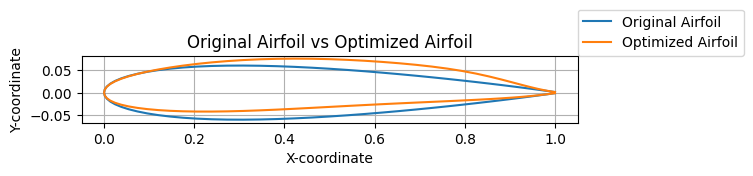

In [14]:
plt.plot(x, y, label = "Original Airfoil")
plt.plot(x, y_opt, label = "Optimized Airfoil")
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Original Airfoil vs Optimized Airfoil')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend(loc=(1,1))
plt.grid()

Text(0, 0.5, 'Y-coordinate')

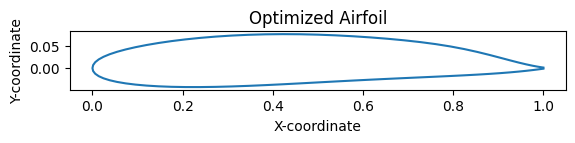

In [15]:
plt.plot(x,y_opt)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Optimized Airfoil')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
# plt.grid()

In [16]:
df_opt = pd.DataFrame({'x': x, 'y_modified': y_opt})
path = "Optimized_airfoil_2.dat"
df_opt.to_csv(path, index=False, sep=' ')

In [17]:
airfoil_name = 'Optimized_airfoil_2'

CL, CD = Xfoil_runner(alpha, Re, n_iter, airfoil_name)

print(CL, CD)

0.8119 0.01039


In [18]:
print('Surrogate model optimization:')
print("Optimal Design Parameters:", optimal_design_parameters)
print("Optimal Lift Coefficient(Surrogate model prediction):", CL_opt )
print("Optimal Drag Coefficient(Surrogate model prediction):", CD_opt)
print("Optimal Aerodynamic Efficiency:", optimal_efficiency)
print("Lift Coefficient for Optimal Design Parameter from XFOIL:", CL )
print("Drag Coefficient for Optimal Design Parameter from XFOIL:", CD)
Opt_eff = CL/CD
print("Optimal Aerodynamic Efficiency from XFOIL:", Opt_eff)

Surrogate model optimization:
Optimal Design Parameters: [[-0.00347148  0.01189391  0.012       0.01198596  0.00846466  0.0091137
   0.00931093  0.00137869]]
Optimal Lift Coefficient(Surrogate model prediction): 0.7327564
Optimal Drag Coefficient(Surrogate model prediction): 0.008480075
Optimal Aerodynamic Efficiency: 86.40919
Lift Coefficient for Optimal Design Parameter from XFOIL: 0.8119
Drag Coefficient for Optimal Design Parameter from XFOIL: 0.01039
Optimal Aerodynamic Efficiency from XFOIL: 78.1424446583253


In [19]:
print("Error%")
print("Lift Coefficient Error:", abs((CL_opt-CL)*100/CL))
print("Drag Coefficient Error:", abs((CD_opt-CD)*100/CD))
print("Optimal Aerodynamic Efficiency Error:", abs((Opt_eff-optimal_efficiency)*100/Opt_eff))

Error%
Lift Coefficient Error: 9.74795217804169
Drag Coefficient Error: 18.382340563502414
Optimal Aerodynamic Efficiency Error: 10.579068385581266


In [20]:
Org_Eff = CL_org/CD_org
print("Improvement in Efiiciency")
print("Lift and Drag Coefficient of Original Airfoil:", CL_org , CD_org)
print("Efiiciency of Original Airfoil:", CL_org/CD_org)
print("Lift and Drag Coefficient of Optimized Airfoil:", CL ,CD)
print("Efiiciency of Optimized Airfoil:", Opt_eff)
print("Improvement in Efiiciency:", ((Opt_eff-Org_Eff)*100/Org_Eff),"%")

Improvement in Efiiciency
Lift and Drag Coefficient of Original Airfoil: 0.5572 0.00848
Efiiciency of Original Airfoil: 65.70754716981132
Lift and Drag Coefficient of Optimized Airfoil: 0.8119 0.01039
Efiiciency of Optimized Airfoil: 78.1424446583253
Improvement in Efiiciency: 18.924610678858322 %


In [21]:
# Return to the original directory
os.chdir(original_directory)
opt_row = optimal_design_parameters.reshape(8)
opt_row = np.append(opt_row,CL)
opt_row = np.append(opt_row,CD)
opt_row

array([-0.00347148,  0.01189391,  0.012     ,  0.01198596,  0.00846466,
        0.0091137 ,  0.00931093,  0.00137869,  0.8119    ,  0.01039   ])

In [22]:
new_dataset = pd.read_excel('new_dataset.xlsx')
new_dataset.drop(columns=['Unnamed: 0'], inplace=True)
new_dataset

,x1,x2,x3,x4,x5,x6,x7,x8,CL,CD
0,0.00840,0.010400,-0.003300,-0.003300,-0.008600,0.001500,-0.001900,-0.002700,0.5294,0.00733
1,-0.00450,-0.003500,0.005700,0.006200,0.010600,-0.006000,0.010100,0.003700,0.6747,0.00947
2,-0.00930,0.003800,-0.008300,-0.011300,0.003000,-0.002800,-0.009300,0.008500,0.4693,0.00959
3,0.00190,-0.009300,0.006700,0.002500,-0.001200,0.007700,0.002600,-0.009200,0.5034,0.00928
4,0.00450,0.001700,0.002600,0.005000,-0.003900,0.003400,-0.008700,0.010500,0.6249,0.00916
...,...,...,...,...,...,...,...,...,...,...
136,-0.01020,-0.008500,0.009500,0.011000,0.009900,-0.004300,-0.011600,0.003800,0.5355,0.01029
137,-0.00910,-0.009900,0.008800,0.012900,0.011200,-0.005100,-0.013000,0.003300,0.5286,0.01027
138,-0.00980,-0.009000,0.009300,0.011800,0.010600,-0.005800,-0.011100,0.003000,0.5305,0.01025
139,-0.01100,-0.009200,0.007900,0.012100,0.009600,-0.004600,-0.012400,0.004500,0.5294,0.01050


In [23]:
l = len(new_dataset)
l

141

In [24]:
new_dataset.loc[l] = opt_row
new_dataset

,x1,x2,x3,x4,x5,x6,x7,x8,CL,CD
0,0.008400,0.010400,-0.003300,-0.003300,-0.008600,0.001500,-0.001900,-0.002700,0.5294,0.00733
1,-0.004500,-0.003500,0.005700,0.006200,0.010600,-0.006000,0.010100,0.003700,0.6747,0.00947
2,-0.009300,0.003800,-0.008300,-0.011300,0.003000,-0.002800,-0.009300,0.008500,0.4693,0.00959
3,0.001900,-0.009300,0.006700,0.002500,-0.001200,0.007700,0.002600,-0.009200,0.5034,0.00928
4,0.004500,0.001700,0.002600,0.005000,-0.003900,0.003400,-0.008700,0.010500,0.6249,0.00916
...,...,...,...,...,...,...,...,...,...,...
137,-0.009100,-0.009900,0.008800,0.012900,0.011200,-0.005100,-0.013000,0.003300,0.5286,0.01027
138,-0.009800,-0.009000,0.009300,0.011800,0.010600,-0.005800,-0.011100,0.003000,0.5305,0.01025
139,-0.011000,-0.009200,0.007900,0.012100,0.009600,-0.004600,-0.012400,0.004500,0.5294,0.01050
140,0.007520,0.011431,-0.011231,0.011868,-0.004313,0.002103,0.011999,0.011648,0.7296,0.00851


In [25]:
# new_dataset.to_excel('new_dataset.xlsx')